# Generator de întrebări în funcție de dificultate

### Biblioteci

In [77]:
# %pip install matplotlib
# %pip install pandas
# %pip install numpy
# %pip install scipy
# %pip install nltk
# %pip install scikit-learn
# %pip install seaborn
# %pip install transformers

### Citire Date

In [78]:
import pandas as pd

with open("dataset.txt", "r", encoding="utf-8") as f:
    lines = f.readlines()

context_text = "".join(lines[1:]).strip()

### Generare Întrebări

In [79]:
from transformers import T5ForConditionalGeneration, T5Tokenizer
import torch

model_name = "valhalla/t5-base-e2e-qg"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

In [80]:
import nltk
from nltk.tokenize import sent_tokenize

nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [81]:
sentences = sent_tokenize(context_text)

chunk_size = 2
chunks = [" ".join(sentences[i:i + chunk_size]) for i in range(0, len(sentences), chunk_size)]

all_questions = []

for idx, chunk in enumerate(chunks, 1):

    input_text = "generate questions: " + chunk
    input_ids = tokenizer.encode(input_text, return_tensors="pt", truncation=True)

    output_ids = model.generate(
        input_ids=input_ids,
        max_length=256,
        num_beams=4,
        length_penalty=1.5,
        no_repeat_ngram_size=3,
        early_stopping=True
    )

    decoded = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    questions = decoded.split("<sep>") if "<sep>" in decoded else [decoded]

    for q in questions:
      # ignora intrebarile goale
      q_add = q.strip()
      if not q_add:
        continue
      all_questions.append({
          "context": chunk,
          "question": q_add
      })

In [82]:
print("\nTotal întrebări generate:", len(all_questions))
print("\nExemplu:")
print(all_questions[0])


Total întrebări generate: 122

Exemplu:
{'context': 'In this book, we’ll use the public Internet, a specific computer network, as our principal\nvehicle for discussing computer networks and their protocols. But what is the\nInternet?', 'question': 'What is the name of the computer network discussed in this book?'}


### Euristică

In [83]:
from nltk.corpus import stopwords, wordnet as wn
from sentence_transformers import SentenceTransformer, util
import nltk
from nltk.tokenize import word_tokenize
import string

nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [84]:
heuristic_model = SentenceTransformer('all-MiniLM-L6-v2')

def ambiguity_score(question):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(question.lower())

    # eliminare semne de punctuatie si stopwords
    filtered_tokens = [
        t for t in tokens
        if t not in stop_words and t not in string.punctuation
    ]

    # calculam numarul de sensuri pentru fiecare cuvant valid
    senses = [len(wn.synsets(t)) for t in filtered_tokens if wn.synsets(t)]

    if senses:
        avg_senses = sum(senses) / len(senses)
    else:
        # caz in care nu exista cuvinte semnificative
        avg_senses = 0

    return avg_senses

In [85]:
def semantic_similarity(context, question):

    embeddings = heuristic_model.encode([context, question], convert_to_tensor=True)
    score = util.cos_sim(embeddings[0], embeddings[1])
    return float(score)

In [86]:
context = """
The Internet is a computer network that interconnects millions of computing devices throughout the world. These devices include not just traditional PCs, but also smartphones, tablets, TVs, and even home appliances. End systems are connected by communication links and packet switches. The Internet uses protocols like TCP and IP to transfer information between devices.
"""

question = "What protocols does the Internet use to transfer data?"

ambiguity = ambiguity_score(question)
similarity = semantic_similarity(context, question)

ambiguity, similarity

(6.8, 0.6581790447235107)

In [87]:
def difficulty_score(question, context, alpha=0.6, beta=0.4):
    amb = ambiguity_score(question)
    sim = semantic_similarity(question, context)
    difficulty = alpha * amb + beta * (1 - sim)
    return difficulty

In [88]:
context = "The Internet is a global network of computers that communicate using protocols like TCP/IP."
question = "What is the Internet?"

print("Scor dificultate:", difficulty_score(question, context))

Scor dificultate: 0.6920180797576905


In [89]:
alpha = 0.6
beta = 0.4

for item in all_questions:

  question = item["question"]
  context = item["context"]

  ambig = ambiguity_score(question)
  sim_score = semantic_similarity(context, question)

  item["ambiguity_score"] = ambig
  item["similarity_score"] = sim_score

In [90]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

f1_scores = np.array([q["ambiguity_score"] for q in all_questions]).reshape(-1, 1)
f2_scores = np.array([q["similarity_score"] for q in all_questions]).reshape(-1, 1)

scaler = MinMaxScaler()

f1_scaled = scaler.fit_transform(f1_scores).flatten()
f2_scaled = scaler.fit_transform(f2_scores).flatten()

In [91]:
for i, q in enumerate(all_questions):

    score = alpha * f1_scaled[i] + beta * (1 - f2_scaled[i])
    q["difficulty"] = score

print(all_questions[0])

{'context': 'In this book, we’ll use the public Internet, a specific computer network, as our principal\nvehicle for discussing computer networks and their protocols. But what is the\nInternet?', 'question': 'What is the name of the computer network discussed in this book?', 'ambiguity_score': 8.0, 'similarity_score': 0.6202012300491333, 'difficulty': np.float64(0.24424208961001764)}


### Alegere dificultate întrebări

In [92]:
import pandas as pd

df = pd.DataFrame(all_questions)

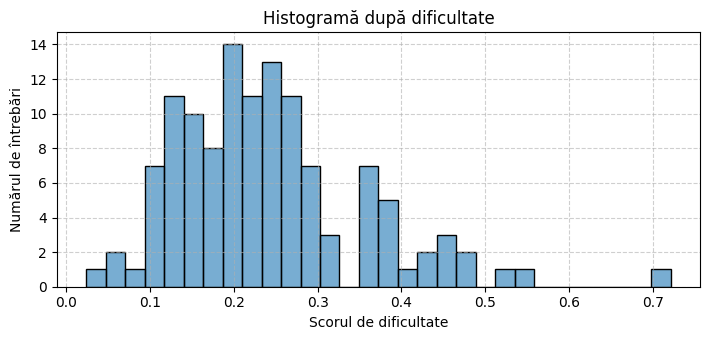

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7.2, 3.5))
sns.histplot(data=df, x="difficulty", bins=30, alpha=0.6)
plt.title("Histogramă după dificultate")
plt.xlabel('Scorul de dificultate')
plt.ylabel('Numărul de întrebări')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [94]:
# ce este peste 5 e greu
# ce este intre 2 si 5 e mediu
# restul sunt usoare

def classify_difficulty(score):
    if score < 0.25:
        return "easy"
    elif score < 0.38:
        return "medium"
    else:
        return "hard"

num_questions = 25

In [95]:
import numpy as np

# daca nu vreau sa aleg empiric pragurile pentru intrebari
# alegem in functie de distributie astfel, 15% intrebari
# vor fi cele dificile, 35% cele medii si restul de 50% sunt
# cele usoare

# extragere scoruri
scores = np.array([q["difficulty"] for q in all_questions])

# calcul procentaj
p50 = np.percentile(scores, 50)
p85 = np.percentile(scores, 85)

def classify_difficulty_non_empiric(score):
  if score < p50:
    return "easy"
  elif score < p85:
    return "medium"
  else:
    return "hard"


In [96]:
print(p50)
print(p85)

0.2202993347079203
0.35963546371348165


In [97]:
def normalize(value, min_val, max_val):
    # evita divizarea la zero
    if max_val == min_val:
        return 0.0
    return (value - min_val) / (max_val - min_val)

In [98]:
difficulty_to_be = "medium"
filtered_questions = []

ambig_min = float('inf')
ambig_max = float('-inf')
sim_min = float('inf')
sim_max = float('-inf')

while len(filtered_questions) < num_questions:

  for chunk in chunks:

    input_text = "generate questions: " + chunk
    input_ids = tokenizer.encode(input_text, return_tensors="pt", truncation=True)

    output_ids = model.generate(
        input_ids=input_ids,
        max_length=256,
        num_beams=4,
        length_penalty=1.5,
        no_repeat_ngram_size=3,
        early_stopping=True
    )

    decoded = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    questions = decoded.split("<sep>") if "<sep>" in decoded else [decoded]

    for item in questions:

      question = item.strip()
      # ignora intrebarile goale
      if not question:
        continue
      context = chunk

      ambig = ambiguity_score(question)
      sim_score = semantic_similarity(context, question)

      # normalizare
      ambig_min = min(ambig_min, ambig)
      ambig_max = max(ambig_max, ambig)
      sim_min = min(sim_min, sim_score)
      sim_max = max(sim_max, sim_score)

      scaled_ambig = normalize(ambig, ambig_min, ambig_max)
      scaled_sim = normalize(sim_score, sim_min, sim_max)

      diff = alpha * scaled_ambig + beta * (1 - scaled_sim)

      if classify_difficulty_non_empiric(diff) == difficulty_to_be:
          filtered_questions.append({
            "context": context,
            "question": question,
            "difficulty": diff
        })

      if len(filtered_questions) > num_questions:
        break

In [99]:
for iter in range(len(filtered_questions)):

  print(filtered_questions[iter])

{'context': 'Increasingly,\nhowever, nontraditional Internet end systems such as laptops, smartphones, tablets,\nTVs, gaming consoles, Web cams, automobiles, environmental sensing devices,\npicture frames, and home electrical and security systems are being connected to the\nInternet. Indeed, the term computer network is beginning to sound a bit dated, given\nthe many nontraditional devices that are being hooked up to the Internet.', 'question': 'Laptops, smartphones, tablets, TVs, gaming consoles, Web cams, automobiles, environmental sensing devices, picture frames, and home electrical and security systems are being connected to what?', 'difficulty': 0.33632478599574545}
{'context': 'Overall, more there are an estimated 2 billion Internet users [ITU 2011]. End systems are connected together by a network of communication links and\npacket switches.', 'question': 'What is the estimated number of Internet users?', 'difficulty': 0.3412926758189792}
{'context': 'When one end system has data